## Задание 1

### Текст задания:
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import requests
from urllib.parse import urlencode

from scipy.stats import norm, mannwhitneyu, shapiro
from scipy.stats import chi2_contingency
from scipy.stats import levene
from tqdm.auto import tqdm
from scipy.stats import ttest_ind

In [2]:
def get_data_from_Yandex_disk(url, sep):
    """ 
    Возвращает df из файла с .csv-расширением, хранящегося на Яндекс-диске,
    url - путь на Яндекс-диск,
    sep - разделитель в файле csv
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
       
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep=sep)
    return df

In [3]:
# Загружаем файлы при помощи созданной функции
groups = get_data_from_Yandex_disk("https://disk.yandex.ru/d/jyT8UrFH3OtIHQ", sep=';')
group_add = get_data_from_Yandex_disk("https://disk.yandex.ru/d/hH_80polNPR4Ag", sep=',')
active_studs = get_data_from_Yandex_disk("https://disk.yandex.ru/d/mV4V4shrYbZUOA", sep=';')
checks = get_data_from_Yandex_disk("https://disk.yandex.ru/d/CXNfyVyanGuFbA", sep=';')

In [4]:
# присоединим доп.информацию 
groups = groups.append(group_add, ignore_index=True)

Цель проведения A/B-теста - улучшение целевых метрик, при сохранении необходимого уровня остальных метрик. 
Для оценки эффективности той или иной акции используется 2 группы метрик: количественные и доходные.

**Под количественными метриками** мы в данном случае можем понимать долю платящих клиентов.

**Когда речь идет о метриках, связанных с монетизацией,** обычно имеют в виду следующие: Общий доход (Revenue) и средние величины: ARPU, ARPPU, средний или медианный чеки.

Для начала проведем первичную оценку данных, проверим их на наличие отсутствующих значений и аномалий.

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.shape

(74576, 2)

In [7]:
groups.describe()

,id
count,7.457600e+04
mean,2.165617e+06
std,2.786959e+06
min,1.489000e+03
25%,9.197188e+05
50%,1.669752e+06
75%,3.328121e+06
max,2.010677e+08


In [8]:
groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
groups.nunique()

id     74576
grp        2
dtype: int64

In [11]:
groups.value_counts('grp')

grp
B    59883
A    14693
dtype: int64

In [12]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
active_studs.shape

(8341, 1)

In [14]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks['rev'].describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [17]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [18]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [19]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [20]:
# Присоединим к данным о группах эксперимента данные об id пользователей, которые зашли на платформу, а также покупателей
main_df = pd.merge(left=groups, right=active_studs, how='left', left_on='id', right_on='student_id', validate='one_to_many')
main_df = pd.merge(left=main_df, right=checks, how='left', left_on='id', right_on='student_id', validate='one_to_many')

In [21]:
main_df.head()

,id,grp,student_id_x,student_id_y,rev
0,1489,B,NaN,NaN,NaN
1,1627,A,1627.0,1627.0,990.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [22]:
main_df.dtypes

id                int64
grp              object
student_id_x    float64
student_id_y    float64
rev             float64
dtype: object

In [23]:
# Проверим, что все корректно: размер соотносится с active_studs.shape
main_df.student_id_x.isna().value_counts()

True     66235
False     8341
Name: student_id_x, dtype: int64

In [24]:
# Проверим, что все корректно: размер соотносится с checks.shape
main_df.student_id_y.isna().value_counts()

True     74035
False      541
Name: student_id_y, dtype: int64

In [25]:
# Проверим, что все корректно: отсутствуют student_id_y без указания полученной выручки
main_df.query('student_id_y <= 0 and rev < 0')

,id,grp,student_id_x,student_id_y,rev


In [26]:
#main_df.drop('student_id_y', axis=1, inplace=True)

In [27]:
main_df.rename(columns={'student_id_x': 'visited_students', 'student_id_y': 'paying_students'}, inplace=True)

In [28]:
main_df

,id,grp,visited_students,paying_students,rev
0,1489,B,NaN,NaN,NaN
1,1627,A,1627.0,1627.0,990.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,NaN
74572,201032527,B,NaN,NaN,NaN
74573,201067612,B,NaN,NaN,NaN
74574,201067653,B,NaN,NaN,NaN


In [29]:
# Отметим студентов, которые были активны в дни эксперимента и посещали сервис
main_df['visited_students'] = main_df.visited_students.apply(lambda x: False if pd.isna(x) else True)

In [30]:
main_df.head()

,id,grp,visited_students,paying_students,rev
0,1489,B,False,NaN,NaN
1,1627,A,True,1627.0,990.0
2,1768,B,False,NaN,NaN
3,1783,B,False,NaN,NaN
4,1794,A,False,NaN,NaN


In [31]:
main_df.visited_students.value_counts()

False    66235
True      8341
Name: visited_students, dtype: int64

In [32]:
# Заменим все значения Nan (пользователи, не совершившие оплату) на нули
main_df.rev.fillna(0, inplace=True)

In [33]:
# сделаем сводную таблицу
pivot_table = pd.pivot_table(main_df, 
                             index='grp', 
                             columns='visited_students', 
                             values=['id', 'paying_students', 'rev'], 
                             aggfunc={'id': 'count', 'paying_students': 'count', 'rev': 'sum'})

In [34]:
pivot_table

id       paying_students              rev             
visited_students  False  True           False True       False         True
grp                                                                        
A                 13155  1538              29   78  19276.0000   72820.0000
B                 53080  6803             120  314  86256.0001  394974.0035

In [35]:
table_for_analysis = pivot_table.stack().reset_index()

In [36]:
table_for_analysis.rename(columns={'visited_students': 'in_experiment', 'id': 'visited_students'}, inplace=True)

Используем следующие метрики:

* ARPU  - средний доход с пользователя группы в момент проведения эксперимента

* ARPPU - средний доход с платящего пользователя группы в момент проведения эксперимента

* CR    - конверсия в покупку в момент проведения эксперимента 

#### CR

С помощью критерия согласия Пирсона проверим, значимы ли различия между группами в доле платящих пользователей. **Н0 =** наблюдаемые частоты соответствуют ожидаемым
**Н1 =** наблюдаемые частоты в группах отличаются от ожидаемых. 
Для этого составим таблицу сопряженности:

In [37]:
table_for_analysis

,grp,in_experiment,visited_students,paying_students,rev
0,A,False,13155,29,19276.0000
1,A,True,1538,78,72820.0000
2,B,False,53080,120,86256.0001
3,B,True,6803,314,394974.0035


In [38]:
table_for_cr = table_for_analysis.loc[:, 'grp':'paying_students'].query('in_experiment == True')

In [39]:
table_for_cr['cr'] = table_for_cr.paying_students / table_for_cr.visited_students * 100

In [40]:
table_for_cr

,grp,in_experiment,visited_students,paying_students,cr
1,A,True,1538,78,5.071521
3,B,True,6803,314,4.615611


In [41]:
table_for_cr.loc[:, 'visited_students': 'paying_students'].values

array([[1538,   78],
       [6803,  314]], dtype=int64)

**Проведем тестирование**

In [42]:
chi, pvalue, k, _ = chi2_contingency(table_for_cr.loc[:, 'visited_students': 'paying_students'].values)

In [43]:
chi

0.43612258061018483

In [44]:
pvalue

0.5089998823014525

In [45]:
k

1

##### Вывод:
Гипотеза об однородности выборок не отвергается. Таким образом, мы можем сказать, что **в результате проведенного теста, количество платящих пользователей значимо не изменилось**

### Метрики дохода

#### ARPU

Разделим данные для удобства анализа на 2 группы: тестовую и контрольную

In [46]:
df_control = main_df.query('grp == "A"')

In [47]:
df_test = main_df.query('grp == "B"')

До начала эксперимента необходимо определить объем выборки, достаточный для того, чтобы различия между метриками были статистически значимы. В данном задании ничего не говорится о том, какое изменение целевых метрик будет призначаться значимым. Т.к. в нашем случае нам целевое изменение не известно, мы можем вычислить какова чувствительность у проведенного теста, при имеющихся объемах выборок, power=0.90 и уровне значимости 5%.

In [48]:
# размер выборки контрольной группы
nx = df_control.shape[0]

In [49]:
# размер выборки тестовой группы
ny = df_test.shape[0]

In [50]:
pg.power_ttest2n(nx=nx, ny=ny, power=0.90, alpha=0.05, alternative='greater')

0.0269420681523298

**Вывод:**
При заданной мощности и объеме выборок, мы можем отследить изменения показателей более 2,7%.

Проведем анализ данных пользователей, попавших в контрольную группу

In [51]:
df_control['rev'].describe()

count    14693.000000
mean         6.268019
std        100.790849
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3660.000000
Name: rev, dtype: float64

In [52]:
df_test['rev'].describe()

count    59883.000000
mean         8.036171
std        113.249998
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4650.000000
Name: rev, dtype: float64

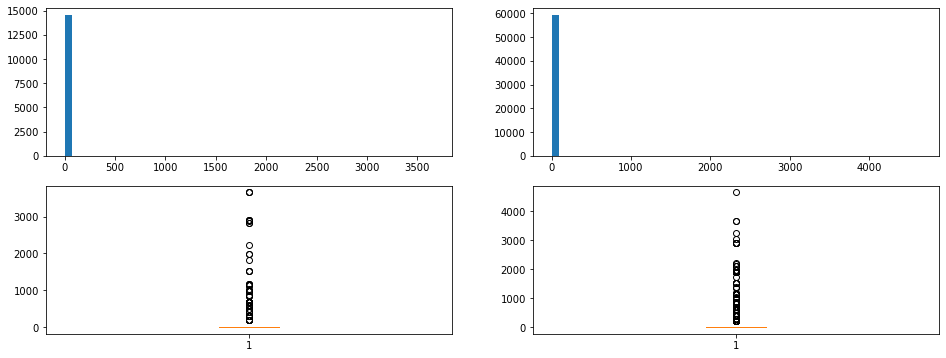

In [53]:
# Распределение оплат 
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
axs[0, 0].hist(df_control.rev, bins=50, label='Control group')
axs[0, 1].hist(df_test.rev, bins=50, label='Test group')
axs[1, 0].boxplot(df_control.rev)
axs[1, 1].boxplot(df_test.rev)
plt.show()

Т.к. ARPU фактически является средним значение в выборке, мы можем применить парный t-тест для их сравнения. Однако, его можно применять при выполнении следующих требований:

требование гомогенности дисперсий. Проверяем с помощью критерия Левена
требование к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения.

In [54]:
# Запускаем тест Левена
stat, p = levene(df_control.rev, df_test.rev)

In [55]:
p

0.08333204995116977

**Вывод:** Результаты теста Левина не позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [56]:
# Убедимся, что распределения не нормальные, используя критерий Шапиро-Уилка, предварительно сэмплируя выборки
# (если P-value меньше 0.05 можно считать распределение не нормальным)
shapiro(df_control.rev.sample(1000, random_state=17)), \
shapiro(df_test.rev.sample(1000, random_state=17))

(ShapiroResult(statistic=0.0681658387184143, pvalue=0.0),
 ShapiroResult(statistic=0.01723027229309082, pvalue=0.0))

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [57]:
test_group_ARPU = df_test.rev

In [58]:
control_group_ARPU = df_control.rev

In [59]:
diff_arpu = (test_group_ARPU.mean() - control_group_ARPU.mean()) / control_group_ARPU.mean() * 100
round(diff_arpu, 2)

28.21

In [60]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,   # числовые значения первой выборки
    data_column_2,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.mean,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

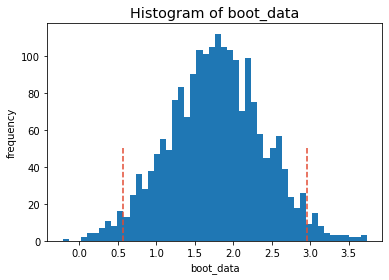

In [61]:
booted_data = get_bootstrap(test_group_ARPU, control_group_ARPU, boot_it=2000)

In [62]:
booted_data["p_value"]

0.0037245028451898476

In [63]:
booted_data["ci"]

,0
0.025,0.566835
0.975,2.963779


##### Вывод: 
**ARPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

### ARPPU

Для того, чтобы расчитать ARPPU, нам нужны данные по платящим пользователям.

In [64]:
ARPPU_by_groups = main_df.query('rev > 0') \
                         .groupby('grp', as_index=False) \
                         .agg({'rev': 'mean'}) \
                         .rename(columns={'rev': 'mean'})
ARPPU_by_groups

,grp,mean
0,A,860.710280
1,B,1108.824893


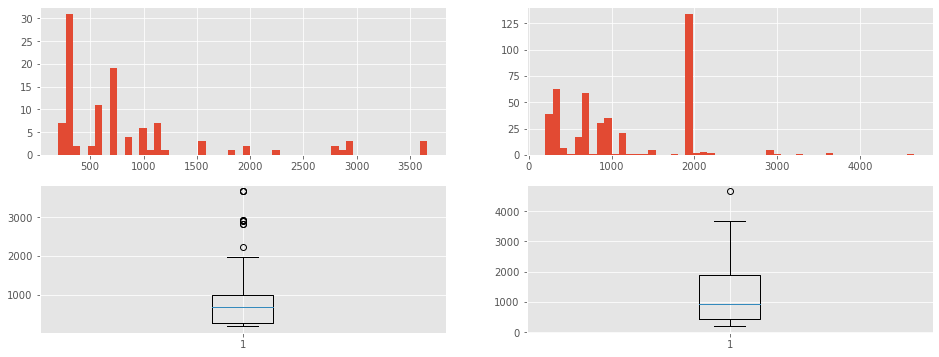

In [65]:
# Распределение по оплате среди всех платящих
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
axs[0, 0].hist(df_control.query('rev > 0').rev, bins=50, label='Control group')
axs[0, 1].hist(df_test.query('rev > 0').rev, bins=50, label='Test group')
axs[1, 0].boxplot(df_control.query('rev > 0').rev)
axs[1, 1].boxplot(df_test.query('rev > 0').rev)
plt.show()

Как мы видим, распределение не является нормальным

Т.к. ARPPU фактически является средним значение в выборке, мы можем применить аналогичный порядок действий, который применяли по отношению к ARPU.
Порядок действий:
1. проверка на соответствие требованию гомогенности дисперсий. Проверяем с помощью критерия Левена
2. проверка на соответствие требованию к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения
3. парный t-тест для сравнения, если предыдущие условия выполняются.

In [66]:
df_control_arppu = df_control.query('rev > 0')

In [67]:
df_test_arppu = df_test.query('rev > 0')

In [68]:
diff_arppu = (df_test_arppu['rev'].mean() - df_control_arppu['rev'].mean()) / df_control_arppu['rev'].mean() * 100
round(diff_arppu, 2)

28.83

In [69]:
# Запускаем тест Левена
stat, p = levene(df_control_arppu.rev, df_test_arppu.rev)

In [70]:
p

0.03477352573759214

**Вывод:** Результаты теста Левина не позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [71]:
# Убедимся, что распределения не нормальные, используя критерий Шапиро-Уилка
# (если P-value меньше 0.05 можно считать распределение не нормальным)
shapiro(df_control.query('rev > 0').rev), \
shapiro(df_test.query('rev > 0').rev)

(ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13),
 ShapiroResult(statistic=0.8672363758087158, pvalue=8.947892893418603e-19))

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [72]:
test_group_ARPPU = df_test_arppu.rev

In [73]:
control_group_ARPPU = df_control_arppu.rev

  0%|          | 0/2000 [00:00<?, ?it/s]

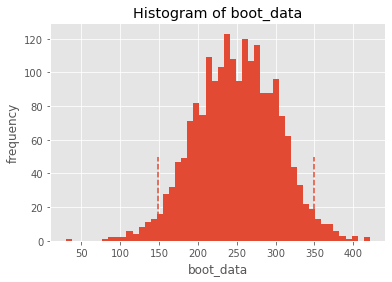

In [74]:
booted_data = get_bootstrap(test_group_ARPPU, control_group_ARPPU, boot_it=2000)

In [75]:
booted_data["p_value"]

1.8911734355446357e-06

In [76]:
booted_data["ci"]

,0
0.025,148.315907
0.975,349.360090


**ARPPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

## Общие выводы по заданию 1

**Основные гипотезы для анализа результатов теста**

**Нулевая гипотеза.** Все механики оплаты имеют одинаковые показатели платежной эффективности. Другими словами, нет эффекта или нет разницы между применением разных механик оплат.

**Альтернативная гипотеза.** Между разными механиками оплат есть статистически значимая разница.

### Результаты:
Показатель конверсии (CR) не различается значимо в тестовой контрольной группе. 
ARPU, ARPPU значимо различаются в тестовой и контрольной группе.
Исходя из этого, мы можем доверять следующим данным:
1. В тестовой группе ARPU выше на 28,21%
2. В тестовой группе ARPPU выше на 28,83%
Метрики дохода значительно выросли, без сокращения конверсии.

Таким образом, мы можем сделать вывод о том, что внедрение новой механики оплаты можно считать успешным.

## Задание 2

### Текст задания:
1) Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

Дана таблица peas:

* st_id(int) - ID ученика
* timest(timestamp) - Время решения карточки
* correct(bool) - Правильно ли решена горошина?
* subject(text) - Дисциплина, в которой находится горошина

In [77]:
SQL_1 = """
    SELECT DISTINCT st_id
    FROM
    (
        SELECT
            st_id,
            COUNT(*) AS peas
        FROM default.peas

        WHERE correct = True
          AND toMonth(timest) = 3
          AND toYear(timest)  = 2020

        GROUP BY st_id, date_trunc('hour', timest)
        HAVING COUNT(*) > 20
    )
"""

2) Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Дана таблицs peas:

* st_id(int) - ID ученика
* timest(timestamp) - Время решения карточки
* correct(bool) - Правильно ли решена горошина?
* subject(text) - Дисциплина, в которой находится горошина

studs:

* st_id(int) - ID ученика
* test_grp(text) - Метка ученика в данном эксперименте

и checks:

* st_id(int) - ID ученика
* sale_time(timestamp) - Время покупки
* money(int) - Цена, по которой приобрели данный курс
* subject(text) - Дисциплина, на которую приобрели полный доступ

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

1. ARPU 
2. ARPAU
3. ARPPU
4. CR в покупку 
5. СR активного пользователя в покупку 
6. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [78]:
SQL_2 = """
    SELECT
        test_grp,
        sum(check.money) / count(DISTINCT studs.st_id)                               AS ARPU,
        sum(check.money) / count(DISTINCT peas.st_id)                                AS ARPAU,
        sum(check.money) / count(DISTINCT checks.st_id)                              AS ARPPU,
        count(DISTINCT check.st_id) / count(DISTINCT studs.st_id)                    AS CR_to_purchase,
        count(DISTINCT check.st_id) / count(DISTINCT peas.st_id)                     AS CR_active_user_to_purchase,
        count(DISTINCT CASE WHEN peas.subject = 'Math' AND check.subject = 'Math' THEN studs.st_id END) 
        / count(DISTINCT CASE WHEN peas.subject = 'Math' THEN studs.st_id END)       AS CR_math
    FROM studs AS st                                                                 -- все пользователи в эксперименте
    LEFT JOIN peas AS p ON st.st_id = p.st_id                                        -- активные пользователи
    LEFT JOIN check AS ch ON st.st_id = ch.st_id                                     -- платящие пользователи
    GROUP BY test_grp

"""

## Задание 3. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [93]:
def add_info_exp(groups, active_studs, checks, link, sep):
    """
    Функция будет автоматически подгружать информацию из дополнительного файла groups_add.csv и пересчитывать метрики.
    Уже имеются следующие данные:
    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.
    """
    group_add = get_data_from_Yandex_disk(link, sep)
    
    # Переименуем заголовки заголовки 
    for i in group_add.columns:
        if group_add[i].dtype == 'int64':
            group_add.rename(columns={i: 'id'}, inplace=True)
        else:
            group_add.rename(columns={i: 'grp'}, inplace=True)
        
    # Добавляем дополнительные данные в df 
    groups = groups.append(group_add, ignore_index=True)
    
    # Присоединим к данным о группах эксперимента данные об id пользователей, которые зашли на платформу, а также покупателей
    main_df = pd.merge(left=groups, right=active_studs, how='left', left_on='id', right_on='student_id')
    main_df = pd.merge(left=main_df, right=checks, how='left', left_on='id', right_on='student_id')
    
    # Переименуем колонки
    main_df.rename(columns={'student_id_x': 'visited_students', 'student_id_y': 'paying_students'}, inplace=True)
    
    # Отметим студентов, которые были активны в дни эксперимента и посещали сервис
    main_df['in_experiment'] = main_df.visited_students.apply(lambda x: False if pd.isna(x) else True)
    
    # Заменим все значения Nan (пользователи, не совершившие оплату) на нули
    main_df.rev.fillna(0, inplace=True)
    
    
    # сделаем таблицу, в которую будем вносить метрики
    df_for_metrics = main_df.query('in_experiment == True')
    metrics = pd.DataFrame(columns=['all_users', 'paying_users', 'revenue', 'ARPU', 'ARPPU', 'CR'], 
                           index=['A', 'B'])
    
    #Считаем метрики:
    metrics['all_users'] = df_for_metrics.groupby('grp').agg({'id': 'count'})
    metrics['paying_users'] = df_for_metrics.groupby('grp').agg({'paying_students': 'count'})
    metrics['revenue'] = df_for_metrics.groupby('grp').agg({'rev': 'sum'})
    metrics['ARPU'] = metrics.revenue / metrics.all_users
    metrics['ARPPU'] = metrics.revenue / metrics.paying_users
    metrics['CR'] = metrics.paying_users / metrics.all_users * 100
    
    return metrics
        

In [86]:
metrics = add_info_exp(groups, active_studs, checks, link="https://disk.yandex.ru/d/sjoWEkWotlDeZQ", sep=',')

In [87]:
metrics

,all_users,paying_users,revenue,ARPU,ARPPU,CR
A,1541,78,72820.0000,47.255029,933.589744,5.061648
B,6813,315,396874.0035,58.252459,1259.917471,4.623514


In [92]:
def make_graphs(metrics):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    sns.barplot(ax=axes[0], data=metrics, x=metrics['ARPU'], y=metrics.index.values)
    sns.barplot(ax=axes[1], data=metrics, x=metrics['ARPPU'], y=metrics.index.values)
    sns.barplot(ax=axes[2], data=metrics, x=metrics['CR'], y=metrics.index.values)

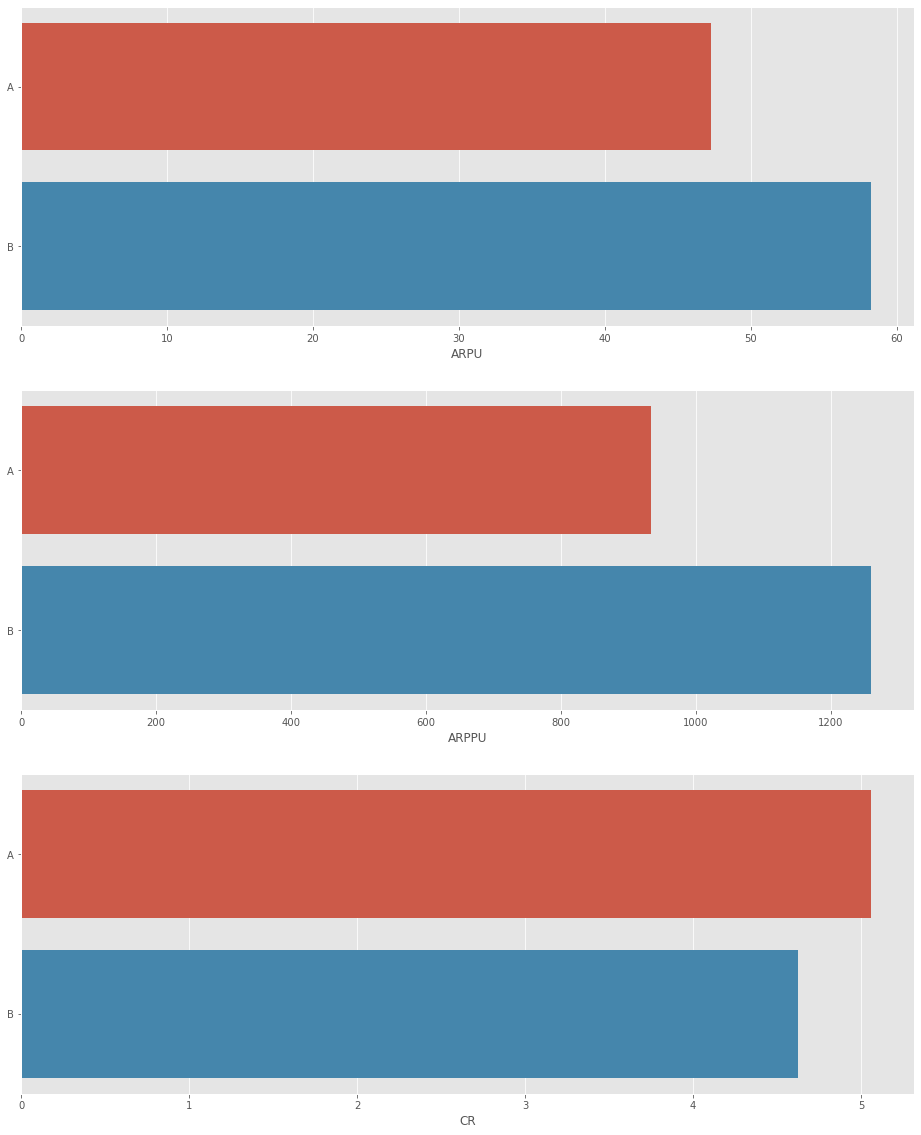

In [89]:
make_graphs(metrics)